# Monge, Bregman and Occam estimator

## The Monge Problem

The Monge Problem delves into identifying, among all possible mappings $T: \mathbb{R}^d \to \mathbb{R}^d$ that push-forward a measure $\mu \in \mathcal{P}\left(\mathbb{R^d}\right)$ 
onto $\nu \in \mathcal{P}\left(\mathbb{R^d}\right)$, and using a cost function $c(\textbf{x}, \textbf{y})$ as a measure of the length of the displacement, the most efficient maps. These optimal mapping are characterized as follows:  
$T^\star := \underset{T\#\mu=\nu }{\arg \inf}\int_{\mathbb{R^d}}^{} c(\textbf{x}, T(\textbf{x}))d\mu$.

## Sparsity inducing costs
Considering a translation-invariant cost function $c(\textbf{x}, \textbf{y}) := h\left(\textbf{x}-T(\textbf{x})\right)$, we will shed the light on particular cost functions that can induce sparse transportations, ie $\left\|\Delta(\textbf{x})  \right\|_0 << d$ where $\Delta(\textbf{x}) := \textbf{x}-T(\textbf{x})\in \mathbb{R}^d$ is the displacement vector.

Elastic costs are functions of the form $c(x, y) = h_\tau(x - y)$ with $h_\tau(z) = \frac{1}{2} \left\|z\right\|_2^2 + \tau(z)$. $\tau$ is a regularizer that, generally speaking, can be any regularizer as long as its proximal operator is known in closed form.

In [1]:
import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt

import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.geometry.costs import ElasticL1
from ott.tools import sinkhorn_divergence

In [2]:
from ott.tools.gaussian_mixture import (
    gaussian_mixture,
)

In [3]:
rng = jax.random.PRNGKey(1)

d = 200

mean_generator0 = jnp.array([[0.0]*(i) + [2.0] + [0.0]*(d-i-1) for i in range(d)])
cov_generator0 =  jnp.array(
    [
    np.diag([0.3]*i + [0.05] + [0.3]*(d-i-1)).tolist() for i in range(d)
    ]
)
weights_generator0 = jnp.array([1.0]*d)

gmm_generator0 = (
    gaussian_mixture.GaussianMixture.from_mean_cov_component_weights(
        mean=mean_generator0,
        cov=cov_generator0,
        component_weights=weights_generator0,
    )
)

mean_generator1 = jnp.array([[0.0 for _ in range(d)]])
cov_generator1 = jnp.array(
    [
        np.diag([0.2 for _ in range(d)]).tolist(),
    ]
)
weights_generator1 = jnp.array([1.0])

gmm_generator1 = (
    gaussian_mixture.GaussianMixture.from_mean_cov_component_weights(
        mean=mean_generator1,
        cov=cov_generator1,
        component_weights=weights_generator1,
    )
)


In [ ]:
N = 1000
rng, rng1, rng2 = jax.random.split(rng, num=3)
x = samples_gmm0 = gmm_generator0.sample(rng=rng1, size=N)
y = samples_gmm1 = gmm_generator1.sample(rng=rng2, size=N)

: 

In [4]:
plt.figure(figsize=(12, 6))
plt.scatter(samples_gmm0[:, 0], samples_gmm0[:, 1], edgecolors="k", marker="o", alpha=0.5)
plt.scatter(samples_gmm1[:, 0], samples_gmm1[:, 1], edgecolors="k", marker="X", alpha=0.5)
plt.show()

NameError: name 'samples_gmm0' is not defined

<Figure size 1200x600 with 0 Axes>

## Map with the regular l2 norm

In [ ]:
solver = jax.jit(sinkhorn.Sinkhorn())


def entropic_map(x, y, cost_fn: costs.TICost) -> jnp.ndarray:
    geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn)
    output = solver(linear_problem.LinearProblem(geom))
    dual_potentials = output.to_dual_potentials()
    return dual_potentials.transport


map = entropic_map(x, y, costs.SqEuclidean())

In [ ]:
new = gmm_generator0.sample(rng=rng, size=N)

In [5]:
sparsity_l2 = ((new - map(new)) < 1e-6).mean(axis=1).mean()
sink_l2 = sinkhorn_divergence.sinkhorn_divergence(pointcloud.PointCloud, map(new), y, cost_fn=costs.SqEuclidean()).divergence

NameError: name 'new' is not defined

# Using Elastic costs

In [ ]:
cost_fn = ElasticL1

In [ ]:
sparsity = []
sink_div = []

for reg in np.logspace(-2, 3, 10):
    solver = jax.jit(sinkhorn.Sinkhorn())
    cost = pointcloud.PointCloud(x, y, cost_fn=cost_fn(reg))
    prob = linear_problem.LinearProblem(cost)
    out = solver(prob)
    dual_potentials = out.to_dual_potentials()
    map = dual_potentials.transport
    sparsity.append(((new - map(new)) < 1e-6).mean(axis=1).mean())
    sink_div.append((sinkhorn_divergence.sinkhorn_divergence(pointcloud.PointCloud, map(new), y, cost_fn=costs.SqEuclidean()).divergence))

In [6]:
plt.plot(np.logspace(-2, 3, 10), sparsity)
plt.axhline(sparsity_l2, color="r", linestyle="--")
plt.xscale("log")

NameError: name 'sparsity' is not defined

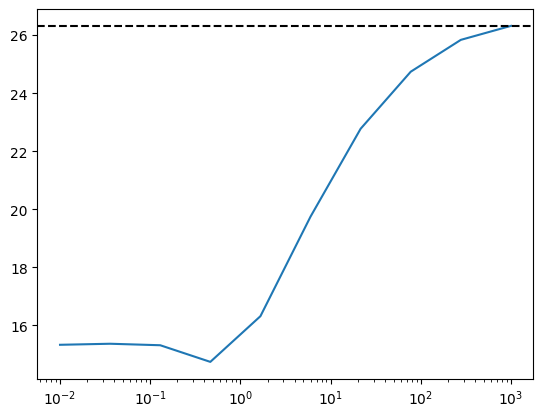

In [ ]:
plt.plot(np.logspace(-2, 3, 10), sink_div)
plt.axhline(sink_l2, color="r", linestyle="--")
plt.xscale("log")